# Projet 3 : Anticipez les besoins en consommation électrique de bâtiments
# Modélisation

## 1. Importation des données

### 1.1. Chargement des librairies

In [1]:
# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Ignorer les warnings
import warnings
warnings.filterwarnings(action='ignore')

# Outils de sklearn
from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline,Pipeline

# Modèles de sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

### 1.2. Chargement des données

In [2]:
data = pd.read_csv("data_for_ML2.csv", index_col = 0)

In [3]:
# afficher sur 47 colonnes
pd.set_option('display.max_column',47)

In [4]:
df1 = data.copy()
df1

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,7.0,1927.0,1,12.0,88434.0,0.0,88434.0,88434.0,0.0,0.0,62.5,7.103895e+06,249.705,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
1,7.0,1996.0,1,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,8.371084e+06,279.685,NonResidential,Hotel,DOWNTOWN,Hotel,Parking,Restaurant
2,7.0,1969.0,1,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,7.285884e+07,2075.380,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
3,7.0,1926.0,1,10.0,61320.0,0.0,61320.0,61320.0,0.0,0.0,28.5,1.751195e+07,1111.385,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
4,7.0,1980.0,1,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,0.0,71.0,1.450085e+07,506.355,NonResidential,Hotel,DOWNTOWN,Hotel,Parking,Swimming Pool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1.0,1982.0,1,1.0,18261.0,0.0,18261.0,18261.0,0.0,0.0,NaN,9.320821e+05,20.330,Nonresidential COS,Other,DELRIDGE,Other - Recreation,None,None
1550,2.0,2004.0,1,1.0,16000.0,0.0,16000.0,16000.0,0.0,0.0,NaN,9.502762e+05,32.170,Nonresidential COS,Other,DOWNTOWN,Other - Recreation,None,None
1551,7.0,1974.0,1,1.0,13157.0,0.0,13157.0,7583.0,5574.0,0.0,NaN,5.765898e+06,223.540,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,Other - Recreation,Fitness Center/Health Club/Gym,Swimming Pool
1552,1.0,1989.0,1,1.0,14101.0,0.0,14101.0,6601.0,6501.0,484.0,NaN,7.194712e+05,22.110,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare


Suite à une remarque dans l'analyse exploratoire, on regarde si la PrimaryPropertyType = Non-Refrigerated Warehouse est toujours là.

In [5]:
df1.loc[df1['PrimaryPropertyType']=='Non-Refrigerated Warehouse']

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
876,2.0,1952.0,1,1.0,27435.0,0.0,27435.0,19120.0,8315.0,0.0,49.0,1231546.0,36.72,NonResidential,Non-Refrigerated Warehouse,SOUTHEAST,Non-Refrigerated Warehouse,Medical Office,None


On va la modifier cette valeur Warehouse.

In [6]:
df1['PrimaryPropertyType'].replace('Non-Refrigerated Warehouse','Warehouse', inplace = True )
df1['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    291
Other                          250
Warehouse                      186
Large Office                   172
Mixed Use Property             104
Retail Store                    86
Hotel                           74
Worship Facility                69
Distribution Center             53
K-12 School                     51
Medical Office                  42
Supermarket / Grocery Store     40
Self-Storage Facility           27
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [7]:
df1.shape

(1554, 19)

# 2. Preprocessing

### 2.1. Feature Engineering : Ajout de la colonne BuildingAge

In [8]:
df1.insert(2, 'BuildingAge', 2016 - df1['YearBuilt'], allow_duplicates=False)
df1.head(5)

,CouncilDistrictCode,YearBuilt,BuildingAge,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,7.0,1927.0,89.0,1,12.0,88434.0,0.0,88434.0,88434.0,0.0,0.0,62.5,7103895.25,249.705,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
1,7.0,1996.0,20.0,1,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,8371084.00,279.685,NonResidential,Hotel,DOWNTOWN,Hotel,Parking,Restaurant
2,7.0,1969.0,47.0,1,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,72858840.00,2075.380,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
3,7.0,1926.0,90.0,1,10.0,61320.0,0.0,61320.0,61320.0,0.0,0.0,28.5,17511952.00,1111.385,NonResidential,Hotel,DOWNTOWN,Hotel,None,None
4,7.0,1980.0,36.0,1,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,0.0,71.0,14500852.50,506.355,NonResidential,Hotel,DOWNTOWN,Hotel,Parking,Swimming Pool


#### Visualisation des valeurs manquantes

In [9]:
# Fonction pour retourner le pourcentage de valeurs manquantes d'un dataframe
# prend en argument le dataframe df

def perc_missing(df) :
    return (df.isna().sum()/df.shape[0] *100).sort_values(ascending = False)

In [10]:
perc_missing(df1)

ENERGYSTARScore                    33.526384
CouncilDistrictCode                 0.000000
YearBuilt                           0.000000
SecondLargestPropertyUseType        0.000000
LargestPropertyUseType              0.000000
Neighborhood                        0.000000
PrimaryPropertyType                 0.000000
BuildingType                        0.000000
TotalGHGEmissions                   0.000000
SiteEnergyUse(kBtu)                 0.000000
ThirdLargestPropertyUseTypeGFA      0.000000
SecondLargestPropertyUseTypeGFA     0.000000
LargestPropertyUseTypeGFA           0.000000
PropertyGFABuilding(s)              0.000000
PropertyGFAParking                  0.000000
PropertyGFATotal                    0.000000
NumberofFloors                      0.000000
NumberofBuildings                   0.000000
BuildingAge                         0.000000
ThirdLargestPropertyUseType         0.000000
dtype: float64

### 2.2. Passage au logarithmique pour les targets SiteEnergyUse(kBtu) et TotalGHGEmissions

Comme vu dans la partie précédente, le passage au log permet de diminuer les valeurs des targets et de "normaliser" leur distribution.

In [11]:
df1_log = df1.copy()
df1_log['SiteEnergyUse(kBtu)'] = df1_log['SiteEnergyUse(kBtu)'].apply(lambda x : np.log(x+1))
df1_log['TotalGHGEmissions'] = df1_log['TotalGHGEmissions'].apply(lambda x : np.log(x+1))
df1_log.describe()

,CouncilDistrictCode,YearBuilt,BuildingAge,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1.554000e+03,1554.000000,1.554000e+03,1.554000e+03,1554.000000,1554.000000,1033.000000,1554.000000,1554.000000
mean,4.425032,1961.416345,54.583655,1.183398,4.240669,1.211092e+05,14444.000644,1.066652e+05,1.004094e+05,19813.637805,3238.246653,62.959826,14.955909,4.033920
std,2.193991,32.870168,32.870168,2.937943,6.716501,3.051161e+05,44613.382038,2.900915e+05,2.855167e+05,52006.041617,18207.657336,28.411413,1.317845,1.447712
min,1.000000,1900.000000,1.000000,1.000000,0.000000,1.128500e+04,0.000000,5.352500e+03,6.455000e+03,0.000000,0.000000,1.000000,10.919951,0.325700
25%,2.000000,1929.250000,28.000000,1.000000,1.000000,2.880200e+04,0.000000,2.788400e+04,2.500000e+04,0.000000,0.000000,43.500000,14.030262,3.076390
50%,4.000000,1965.000000,51.000000,1.000000,2.000000,4.812550e+04,0.000000,4.616425e+04,4.188900e+04,0.000000,0.000000,69.500000,14.801771,3.959050
75%,7.000000,1988.000000,86.750000,1.000000,4.000000,1.080132e+05,0.000000,9.686700e+04,9.284000e+04,13854.500000,0.000000,87.000000,15.808643,4.994395
max,7.000000,2015.000000,116.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,639931.000000,459748.000000,100.000000,20.588504,9.733410


### 2.3. Choix des colonnes

On va éliminer les colonnes suivantes :
- YearBuilt car on a remplacé par la colonne BuildingAge
- BuildingType car on sait qu'on ne travaille pas avec des habitations et PrimaryPropertyType est plus précise.
- LargestPropertyUseType car cette variable peut prendre une cinquantaine de valeurs et redondantes avec PrimaryPropertyType
- SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA car il y a aussi beaucoup de catégories
- PropertyGFABuilding(s), PropertyGFAParking car inclus dans PropertyGFATotal
- LargestPropertyUseTypeGFA car redondante avec PropertyGFATotal

On garde la colonne ENERGYSTARScore car on souhaite évaluer son intérêt.

In [12]:
# Liste des colonnes targets, variables catégorielles et variables numériques
target_columns = ['TotalGHGEmissions','SiteEnergyUse(kBtu)']

cat_columns = ['PrimaryPropertyType','Neighborhood']

num_columns = ['PropertyGFATotal','NumberofFloors','NumberofBuildings','BuildingAge','ENERGYSTARScore']

### 2.4. Créations de fonctions
#### Fonction imputation

In [13]:
# Fonction qui retourne un dataframe avec 
# imputation des valeurs nulles de NumberofFloors par la valeur médiane selon le PrimaryPropertyType
# suppression des valeurs manquantes d'ENERGYSTARScore

# prend en paramètre le dataframe df

def imputation(df) :
    
    for cat in list(df['PrimaryPropertyType'].unique()) :
        for val in df['NumberofFloors'].loc[df['PrimaryPropertyType']==cat] :
            if val ==0 :
                df['NumberofFloors'].loc[
                    df['PrimaryPropertyType']==cat] = df['NumberofFloors'].loc[
                    df['PrimaryPropertyType']==cat].replace(0,
                                                          int(df['NumberofFloors'].loc[
                                                              df['PrimaryPropertyType']==cat].median()))
    return df.dropna(axis=0).reset_index(drop=True)

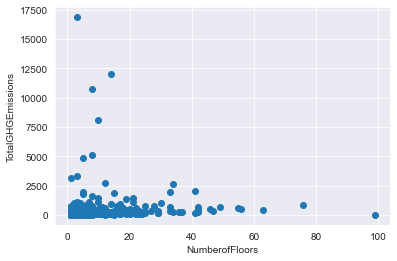

In [14]:
df2 = df1.copy()

# Visualisation de TotalGHGEmissions en fonction de NumberofFloors pour voir si les Outliers sont toujours présents
plt.scatter(x=imputation(df2)['NumberofFloors'], y = imputation(df2)['TotalGHGEmissions'])
plt.xlabel('NumberofFloors')
plt.ylabel('TotalGHGEmissions')
plt.show()

On a toujours nos outliers.

#### Fonction pour récupérer X et y

In [15]:
# fonction pour récupérer X (variables) et y (target) à partir d'un dataset
# prend en paramètres le dataframe df et la colonne cible target (TotalGHGEmissions ou SiteEnergyUse(kBtu))

def X_y(df,target) :
    
    df = imputation(df)
    X = df.drop(target_columns, axis = 1)
    y = df[target]
    
    return X, y

### 2.5. Transformation des variables
#### Variables catégorielles
On va utiliser un OneHotEncoder qui code les variables catégorielles dans une matrice creuse (sparse matrix).
#### Variables numériques
On a vu que nos données comportaient des outliers, et qu'elles n'étaient pas centrées. On va donc les normaliser avec RobustScaler qui rend les variables un peu moins sensibles aux outliers.
#### Définition des transformers

In [16]:
# définition du preprocessor avec un ColumnTransformer en précisant les colonnes et le type de transformer
preprocessor = ColumnTransformer(transformers=[
        ('robust', RobustScaler(), num_columns),
        ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), cat_columns)
    # ignore les erreurs si il y a des catégories inconnues
    ])

## 3. 'Pré-test' pour visualiser l'intérêt du passage au logarithme

On va tester rapidement 3 modèles pour voir l'intérêt du passage au logarithme, notamment sur la courbe d'apprentissage (learning_curve).

### Choix des métriques
On va utiliser la RMSE (Root Mean Squared Error) qui accorde plus d'importance aux grandes erreurs, et est donc plus sensible aux valeurs extremes.
On utilisera également la MAE (Mean Absolute Error).

### Préparation du pré-test

#### Récupération du dataset

In [17]:
df2 = df1[target_columns + num_columns + cat_columns]
df2.shape

(1554, 9)

In [18]:
perc_missing(df2)

ENERGYSTARScore        33.526384
TotalGHGEmissions       0.000000
SiteEnergyUse(kBtu)     0.000000
PropertyGFATotal        0.000000
NumberofFloors          0.000000
NumberofBuildings       0.000000
BuildingAge             0.000000
PrimaryPropertyType     0.000000
Neighborhood            0.000000
dtype: float64

#### Split des données

In [19]:
# 80% des données dans le jeu d'entrainement et 20% dans le jeu de test
trainset, testset = train_test_split(df2, test_size=0.2, random_state=0)
print('Taille du trainset : {}'.format(trainset.shape))
print('Taille du testset : {}'.format(testset.shape))  

Taille du trainset : (1243, 9)
Taille du testset : (311, 9)


#### Taille des variables

In [20]:
# Taille X, y avant encodage
X_train, y_train = X_y(trainset,'TotalGHGEmissions')
X_test, y_test = X_y(testset,'TotalGHGEmissions')
print('Taille X_train : {}'.format(X_train.shape))
print('Taille y_train : {}'.format(y_train.shape))
print('Taille X_test : {}'.format(X_test.shape))
print('Taille y_test : {}'.format(y_test.shape))

Taille X_train : (826, 7)
Taille y_train : (826,)
Taille X_test : (207, 7)
Taille y_test : (207,)


In [22]:
# taille X_train et X_test après encodage
X_train_tfm = preprocessor.fit_transform(X_train)
X_test_tfm = preprocessor.transform(X_test)
print('Taille X_train_tfm : {}'.format(X_train_tfm.shape))
print('Taille X_test : {}'.format(X_test_tfm.shape))

Taille X_train_tfm : (826, 37)
Taille X_test : (207, 37)


#### Mise en place des modèles

In [23]:
# Nombre de k_folds pour diviser le jeu de données d'entrainement
n_folds = KFold(n_splits = 5)

In [24]:
# Modèles testés
LinearReg = make_pipeline(preprocessor,LinearRegression())
DecisionTree = make_pipeline(preprocessor,DecisionTreeRegressor(random_state=42)) 
RandomForest = make_pipeline(preprocessor,RandomForestRegressor(random_state=42))

# Dictionnaire des modèles
dico_model = {'LinearRegression' : LinearReg, 
              'DecisionTreeRegressor' : DecisionTree, 
              'RandomForestRegressor' : RandomForest}

In [25]:
# Fonction qui fait une cross-validation et retourne RMSE et MAE sur le jeu d'entrainement
# prend en paramètres la variable cible target, le type de modèle model et le nom du modèle name

def entrain_model(target, model, name) :

    # Création de X_train, y_train
    X_train, y_train = X_y(trainset,target)
    
    # Cross validation
    scores = cross_validate(model, X_train, y_train, cv = n_folds,
                            scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'])
    
    # Récupération des scores lors de la cross-validation et on prend la moyenne
    RMSE = -scores['test_neg_root_mean_squared_error'].mean()
    MAE = -scores['test_neg_mean_absolute_error'].mean()
    
    return RMSE, MAE

In [26]:
# Fonction qui retourne dans un dataframe les scores de cross_validation pour les modèles testés
# prend en paramètres le dictionnaire des modèles models_dict

def score_model(models_dic) :
    
    # création de listes vides pour stocker les résultats
    RMSE = []
    MAE = []

    for name, model in models_dic.items() : # on boucle sur les modèles
        for target in target_columns : # on boucle sur les targets
            results = entrain_model(target, model, name)
            # on stocke dans les listes les triplettes nom du modèle, target et valeur de RMSE/MAE
            RMSE.append([name, target, results[0]])
            MAE.append([name, target, results[1]])
            
        # Dataframe pour les scores de RMSE
        df_RMSE = pd.DataFrame(RMSE ,columns = ['modèle','target','RMSE'])
        
        # Dataframe pour les scores de MAE
        df_MAE = pd.DataFrame(MAE ,columns = ['modèle','target','MAE'])
        
    # On fusionne les data frame
    resultats = df_RMSE.merge(df_MAE, on = ['modèle','target']) 
    return resultats

In [27]:
# Fonction pour tracer le learning curve d'un modèle
# prend en paramètres le dictionnaire des modèles : models_dic, 
# les valeurs max/min pour RMSE dans le cas du CO2 : y_max_CO2, y_min_CO2 (par défaut 0)
# les valeurs max/min pour RMSE dans le cas de l'energy : y_max_energy, y_min_energy (par défaut 0)

def display_learning_curve(models_dic, y_max_CO2, y_max_energy, y_min_CO2 = 0, y_min_energy = 0) :
    for target in target_columns : # on boucle sur les targets
    
    # Création de X_train, y_train
        X_train, y_train = X_y(trainset,target)
   
        for name, model in models_dic.items() : # on boucle sur les modèles
            # Récupération des données pour le Learning curve
            N,train_score,val_score = learning_curve(model,X_train,y_train, cv = n_folds,
                                                     scoring ='neg_root_mean_squared_error',
                                                     train_sizes = np.linspace(0.1,1,10))
    
            # trace le learning-curve
            plt.figure(figsize=(6,6))
            plt.plot(N,-train_score.mean(axis=1), label='train_score')
            plt.plot(N,-val_score.mean(axis=1),label='validation_score')
            plt.xlabel('Taille du dataset', size = 14)
            plt.ylabel('RMSE moyen', size = 14)
            plt.xlim([50,680])
            
            # Même échelle pour les différents modèles (valeurs choisies après un premier affichage)
            if target == 'TotalGHGEmissions' :
                plt.ylim([y_min_CO2, y_max_CO2])
            else :
                plt.ylim([y_min_energy, y_max_energy])
            plt.title('Learning curve {} for {}'.format(name, target), size = 14)
            plt.legend()
            plt.show()

#### Sans log

In [28]:
score_model(dico_model)

,modèle,target,RMSE,MAE
0,LinearRegression,TotalGHGEmissions,6.067398e+02,2.089317e+02
1,LinearRegression,SiteEnergyUse(kBtu),1.802151e+07,5.906343e+06
2,DecisionTreeRegressor,TotalGHGEmissions,9.268932e+02,1.981866e+02
3,DecisionTreeRegressor,SiteEnergyUse(kBtu),2.891504e+07,5.902506e+06
4,RandomForestRegressor,TotalGHGEmissions,5.975990e+02,1.376082e+02
5,RandomForestRegressor,SiteEnergyUse(kBtu),1.704045e+07,4.195608e+06


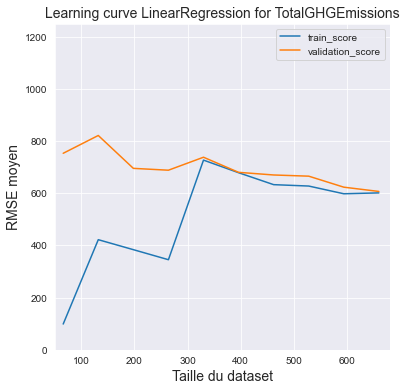

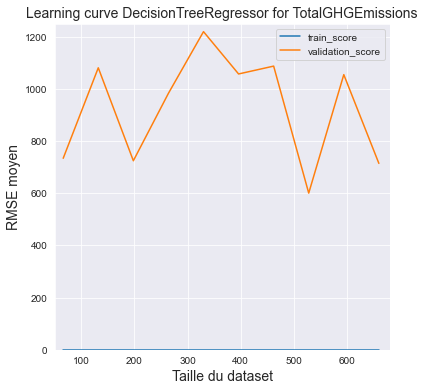

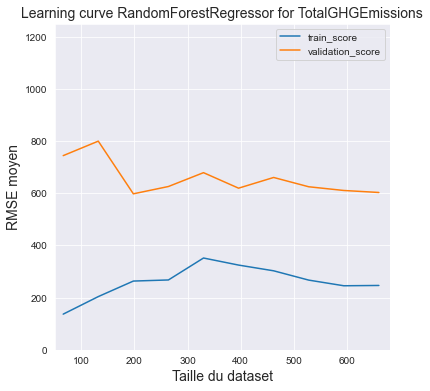

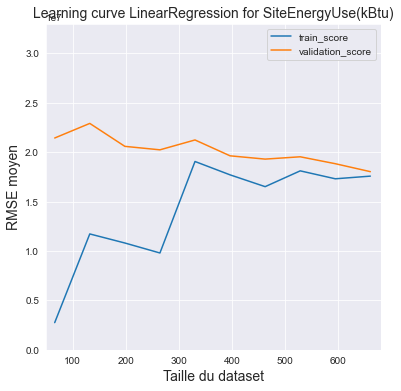

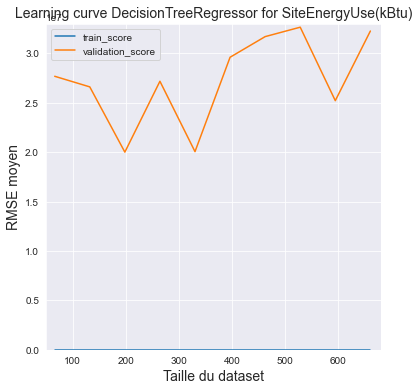

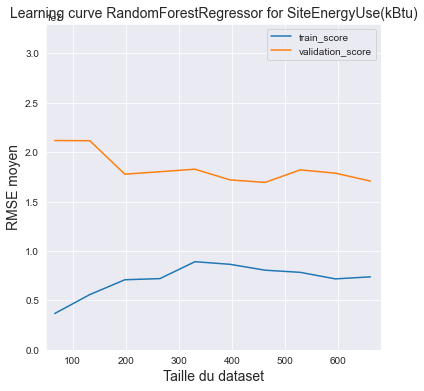

In [29]:
display_learning_curve(dico_model, 1250, 3.3e7)

Les courbes de learning_curve sont oscillantes. DecisionTree a du mal à généraliser.
Pour LinearRegression, les courbes convergent.

Par ailleurs les valeurs de RMSE et MAE sont très élevées, ce qui est difficilement exploitable.

#### Avec log

In [30]:
# Récupération du data set
df2_log = df1_log[target_columns + num_columns + cat_columns]
df2_log.shape

(1554, 9)

In [31]:
# Split des données
trainset, testset = train_test_split(df2_log, test_size=0.2, random_state=0)
print('Taille du trainset : {}'.format(trainset.shape))
print('Taille du testset : {}'.format(testset.shape))  

Taille du trainset : (1243, 9)
Taille du testset : (311, 9)


In [32]:
score_model(dico_model)

,modèle,target,RMSE,MAE
0,LinearRegression,TotalGHGEmissions,1.006595,0.790178
1,LinearRegression,SiteEnergyUse(kBtu),0.734760,0.547774
2,DecisionTreeRegressor,TotalGHGEmissions,1.155173,0.897455
3,DecisionTreeRegressor,SiteEnergyUse(kBtu),0.728659,0.537032
4,RandomForestRegressor,TotalGHGEmissions,0.891907,0.720713
5,RandomForestRegressor,SiteEnergyUse(kBtu),0.546448,0.388127


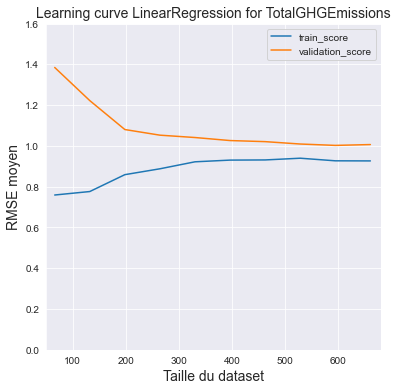

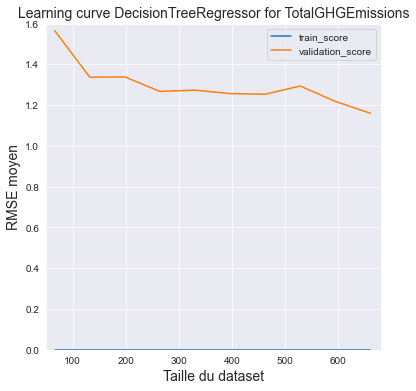

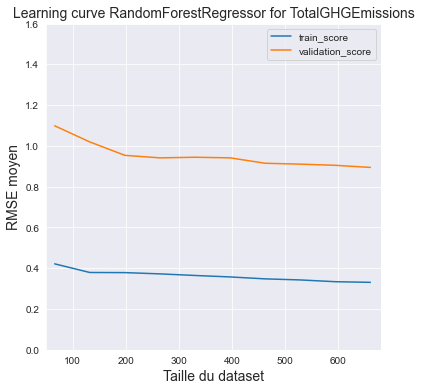

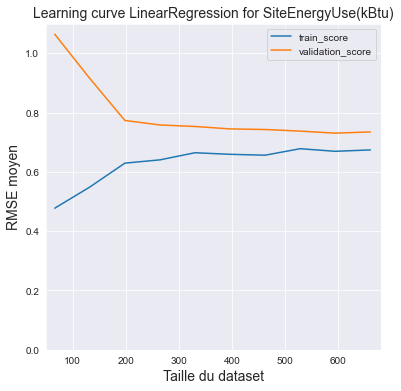

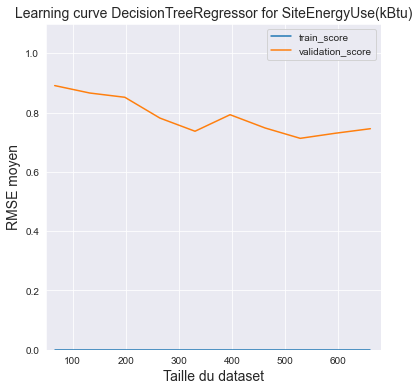

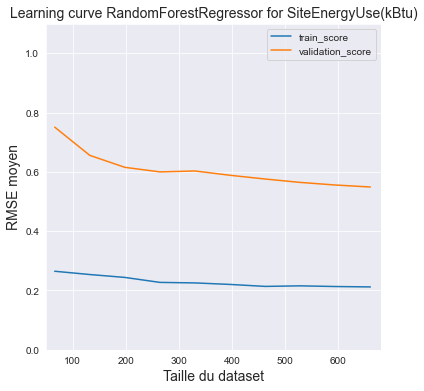

In [33]:
display_learning_curve(dico_model,1.6,1.1)

Les oscillations ont disparu et les modèles apprennent mieux. Pour la LinearReg, les scores convergent et l'écart est faible entre trainset et validationset.
Les 2 targets n'ont pas le même comportement.

On va donc garder nos targets sous forme de logarithme.

## 4. Modélisation

### 4.1. Valeurs par défaut des hyperparamètres
On va créer un dictionnaire des modèles que l'on veut tester.

In [34]:
# Modèles avec valeurs par défaut pour hyperparamètres
Dummy = make_pipeline(preprocessor,DummyRegressor())
# strategy = mean

RandomForest = make_pipeline(preprocessor,RandomForestRegressor(random_state=42))
# n_estimators = 100 ; max_features = auto (max_features=n_features) ; 
# max_depth = None (all leaves pure or until all leaves contain less than min_samples_split samples)

AdaBoost = make_pipeline(preprocessor,AdaBoostRegressor(random_state=42))
# estimator = DecisionTreeRegressor ; n_estimators = 50 ; learning_rate = 1 ; loss = 'linear'

GradBoost = make_pipeline(preprocessor,GradientBoostingRegressor(random_state=42))
# n_estimators = 100 ; learning_rate = 0.1 ; max_depth = 3

LinearReg = make_pipeline(preprocessor,LinearRegression())

LassoReg = make_pipeline(preprocessor,Lasso(random_state=42))
# alpha = 1 ; max_iter = 1000

KernelRidgeReg = make_pipeline(preprocessor,KernelRidge())
# alpha = 1 ; kernel = 'linear'

SVReg = make_pipeline(preprocessor,SVR())
# C = 1 ; kernel = 'rbf' ; epsilon = 0.1

KNR = make_pipeline(preprocessor,KNeighborsRegressor())
# n_neighbors = 5 ; weights = 'uniform' ; metrics = ’minkowski’

ReseauN = make_pipeline(preprocessor,MLPRegressor(random_state=42)) 
# max_iter = 200 ; hidden_layer_sizes = (100,) (1 couche à 100 neurones)

On va tester les modèles 'par paquets' pour que l'ordinateur ne rame pas trop.

#### DummyRegressor / RandomForestRegressor / AdaBoostRegressor / GradientBoostingRegressor

In [36]:
# Dictionnaires des modèles
models_dic = {'Dummy': Dummy,
              'RandomForest': RandomForest,
              'AdaBoost' : AdaBoost,
              'GradBoost' : GradBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' : LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [37]:
tree_RF_ADA_GradBoost = score_model(models_dic)
tree_RF_ADA_GradBoost

,modèle,target,RMSE,MAE
0,Dummy,TotalGHGEmissions,1.405843,1.120506
1,Dummy,SiteEnergyUse(kBtu),1.281964,1.034640
2,RandomForest,TotalGHGEmissions,0.891907,0.720713
3,RandomForest,SiteEnergyUse(kBtu),0.546448,0.388127
4,AdaBoost,TotalGHGEmissions,0.972632,0.810348
5,AdaBoost,SiteEnergyUse(kBtu),0.630421,0.465148
6,GradBoost,TotalGHGEmissions,0.865830,0.695331
7,GradBoost,SiteEnergyUse(kBtu),0.509155,0.366144


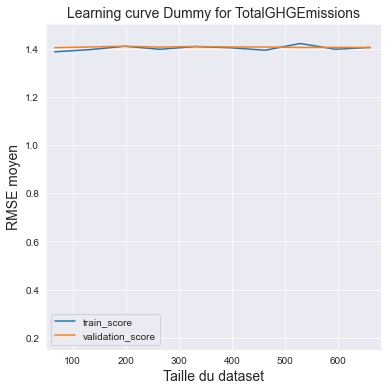

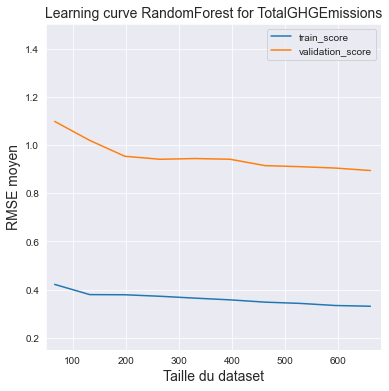

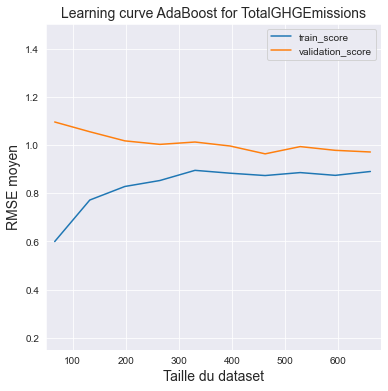

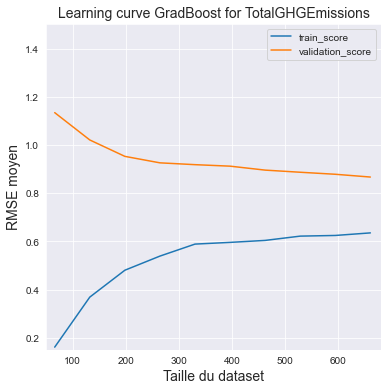

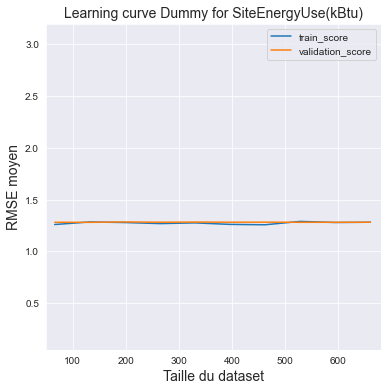

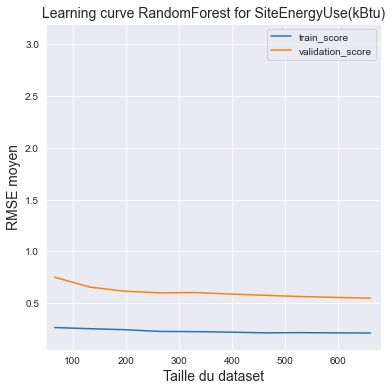

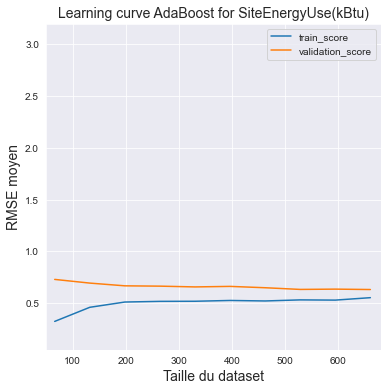

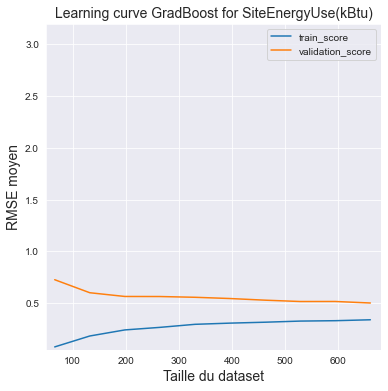

In [38]:
# On garde la même échelle pour l'affichage des scores entre les différents modèles pour pouvoir les comparer
display_learning_curve(models_dic,1.505,3.2,0.15,0.05)

Pour le Dummy, on a des valeurs plus élevées pour le RMSE. Les courbes de trainset et validation set se chevauchent et quelque soit la taille du dataset, le score de RMSE reste à peu près constant. 

On a un écart assez élevé pour la RandomForest entre le trainset et le validation set.
Pour ADA et GradBoosting, les résultats convergent (plus rapidement en terme de taille pour l'AdaBoost, avec un score de RMSE plus élevé). Il faudra régler les hyperparamètres.

#### LinearRegression / Lasso / KernelRidge

In [39]:
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'AdaBoost' : AdaBoost,
              #'GradBoost' : GradBoost,
              'LinearReg' : LinearReg,
              'LassoReg' : LassoReg,
              'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
             # 'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [40]:
linReg_Lasso_Ridge = score_model(models_dic)
linReg_Lasso_Ridge

,modèle,target,RMSE,MAE
0,LinearReg,TotalGHGEmissions,1.006595,0.790178
1,LinearReg,SiteEnergyUse(kBtu),0.734760,0.547774
2,LassoReg,TotalGHGEmissions,1.275299,1.012495
3,LassoReg,SiteEnergyUse(kBtu),1.063351,0.863012
4,KernelRidgeReg,TotalGHGEmissions,1.024953,0.799954
5,KernelRidgeReg,SiteEnergyUse(kBtu),0.946538,0.621684


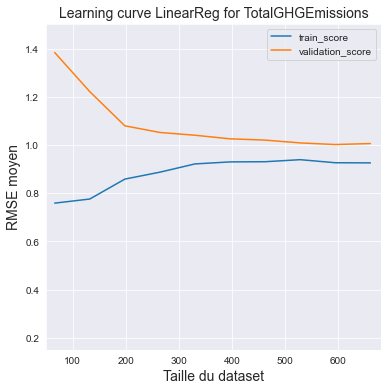

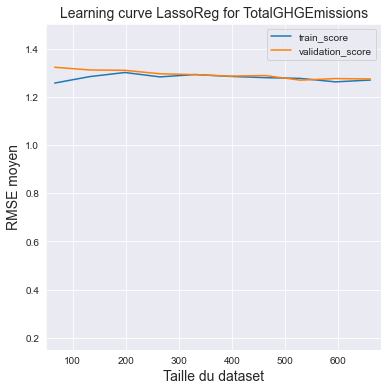

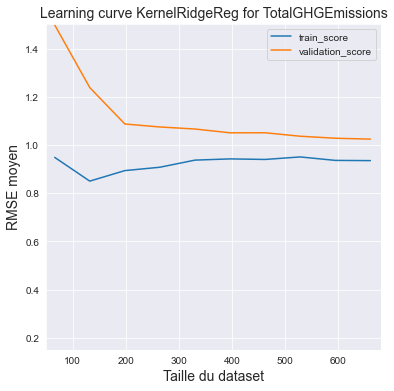

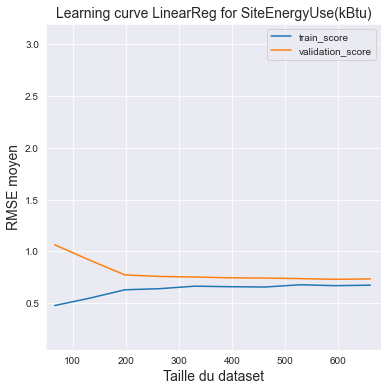

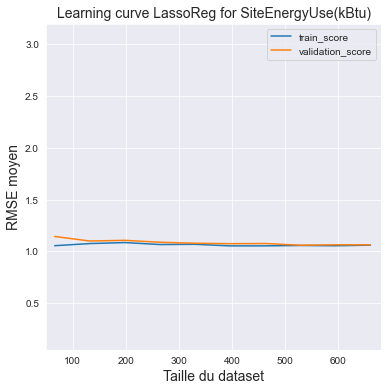

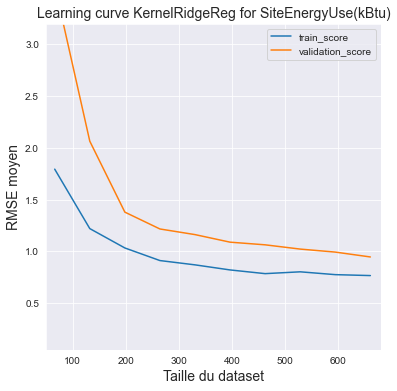

In [41]:
display_learning_curve(models_dic,1.505,3.2,0.15,0.05)

Pour la LinReg, les scores convergent.

Pour le Lasso, on a les courbes qui se chevauchent avec un RMSE plus élevé que pour les autres modèles.

Le KernelRidge, les résultats convergent pour TotalGHGEmissions. Par contre pour SiteEnergyUse(kBtu), il va falloir jouer sur les hyperparamètres pour améliorer l'apprentissage.

#### SVR / KNeighborsRegressor

In [42]:
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'AdaBoost' : AdaBoost,
              #'GradBoost' : GradBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              'KNR' : KNR,
              'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [43]:
KNR_SVR = score_model(models_dic)
KNR_SVR

,modèle,target,RMSE,MAE
0,KNR,TotalGHGEmissions,1.026373,0.806482
1,KNR,SiteEnergyUse(kBtu),0.702103,0.513424
2,SVReg,TotalGHGEmissions,0.924905,0.714850
3,SVReg,SiteEnergyUse(kBtu),0.583533,0.404933


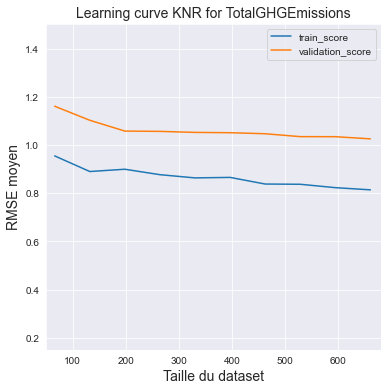

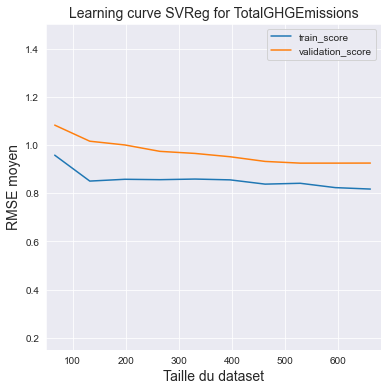

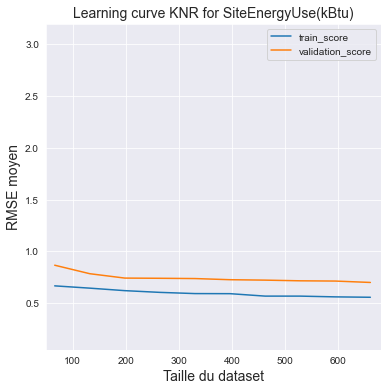

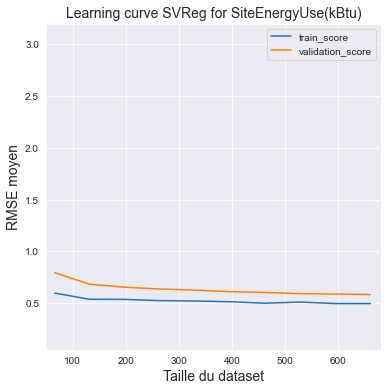

In [44]:
 display_learning_curve(models_dic,1.505,3.2,0.15,0.05)

Pour SiteEnergyUse(kBtu), on voit que les scores se stabilisent très vite avec la taille du dataset.

#### MLPRegressor

In [45]:
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              'ReseauN' : ReseauN
             }

In [46]:
reseauN = score_model(models_dic)
reseauN

,modèle,target,RMSE,MAE
0,ReseauN,TotalGHGEmissions,0.945750,0.712005
1,ReseauN,SiteEnergyUse(kBtu),0.929892,0.550891


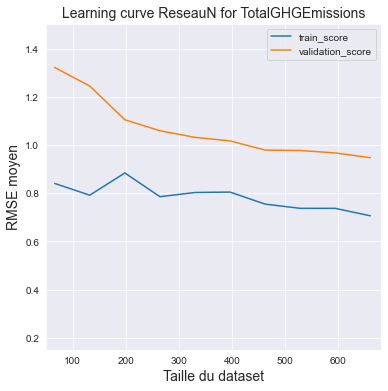

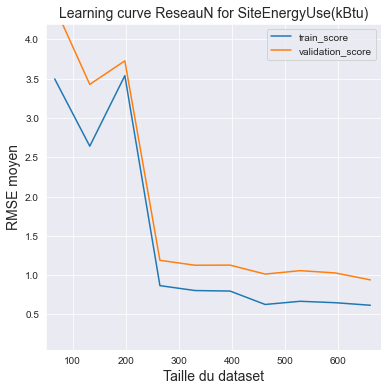

In [47]:
 display_learning_curve(models_dic,1.505,4.2,0.15,0.05)

Pour SiteEnergyUse(kBtu), dès que la taille du dataset dépasse 250, le RMSE se stabilise à peu près dans les trainset et validationset. On remarque qu'il évolue en parallèle dans les 2 sets de données.

#### Affichage des résultats

In [48]:
# Concaténation des différents datafames regroupant les résultats
results_finaux = pd.concat([tree_RF_ADA_GradBoost,linReg_Lasso_Ridge,KNR_SVR,reseauN], 
                           axis = 0).reset_index(drop =True)
results_finaux

,modèle,target,RMSE,MAE
0,Dummy,TotalGHGEmissions,1.405843,1.120506
1,Dummy,SiteEnergyUse(kBtu),1.281964,1.034640
2,RandomForest,TotalGHGEmissions,0.891907,0.720713
3,RandomForest,SiteEnergyUse(kBtu),0.546448,0.388127
4,AdaBoost,TotalGHGEmissions,0.972632,0.810348
5,AdaBoost,SiteEnergyUse(kBtu),0.630421,0.465148
6,GradBoost,TotalGHGEmissions,0.865830,0.695331
7,GradBoost,SiteEnergyUse(kBtu),0.509155,0.366144
8,LinearReg,TotalGHGEmissions,1.006595,0.790178
9,LinearReg,SiteEnergyUse(kBtu),0.734760,0.547774


In [49]:
# Représentation sous forme de barplot des scores de RMSE obtenus sur le jeu d'entrainement pour les modèles testés
# prend en paramètre le dataframe df contenant les résultats

def plot_resultRMSE(df) :
    
    # initialisation de la figure
    plt.figure(figsize=(14,8))
    
    #barplot
    ax =sns.barplot(x='modèle', y ='RMSE', data = df, hue='target')
    plt.ylabel('RMSE', size = 14)
    plt.xlabel('Modèle', size = 14)
    ax.set_xticklabels(df['modèle'].unique(),  size=13)
    
    # ajout des étiquettes pour afficher valeurs de RMSE
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12) 

    plt.show()

In [50]:
# Représentation sous forme de barplot des scores de MAE obtenus sur le jeu d'entrainement pour les modèles testés
# prend en paramètre le dataframe df contenant les résultats

def plot_resultMAE(df) :
    
    # initialisation de la figure
    plt.figure(figsize=(14,8))
    
    # barplot
    ax =sns.barplot(x='modèle', y ='MAE', data = df, hue='target')
    plt.ylabel('MAE-score', size = 14)
    plt.xlabel('Modèle', size = 14)
    ax.set_xticklabels(df['modèle'].unique(),  size=13)
    
    # ajout des étiquettes pour afficher valeurs de MAE
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12) 

    plt.show()

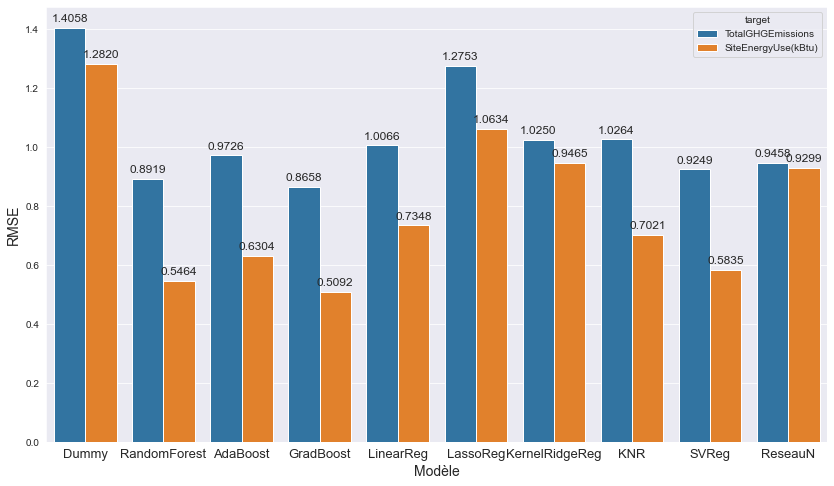

In [51]:
# Affichage des résultats
plot_resultRMSE(results_finaux)

Meilleurs résultats obtenus pour le GradBoost pour les 2 targets.

Top 3 RMSE :
- GradBoost
- RandomForest
- SVReg

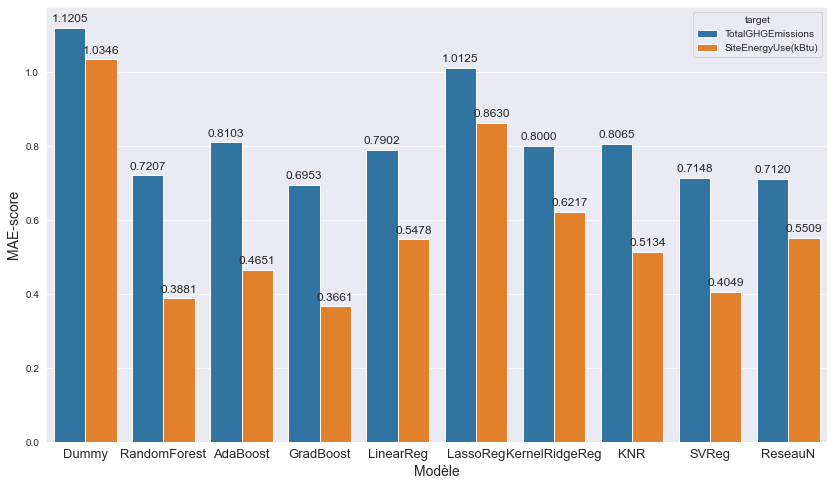

In [52]:
# Affichage des résultats
plot_resultMAE(results_finaux)

Meilleurs résultats obtenus pour le GradBoost.

Top 3 MAE pour TotalGHGEmissions :
- GradBoost
- ReseauN
- SVReg

Top 3 MAE pour SiteEnergyUse(kBtu) :
- GradBoost
- RandomForest
- SVReg

### 4.2. GridSearch sur certains modèles

In [54]:
# Fonction qui effectue le GridSearchCV
# affiche les meilleurs hyperparamètres pour le modèle sélectionné
# retourne le RMSE moyen, le score_r2, le temps d'entrainement du modèle
# prend en paramètres la target target, le modèle model, le dictionnaire des hyperparamètres hyper_params 
# et le score pour GridSearchCV score

def best_param(target, model, hyper_params, score ) :
    
    # Création de X_train, y_train
    X_train, y_train = X_y(trainset,target)
    
    # initialiser la validation croisée
    grid = GridSearchCV(model, param_grid = hyper_params, cv = n_folds, scoring = score)
    
    # Entrainement du modèle
    grid.fit(X_train,y_train)
    
    # Affichage des meilleurs paramètres
    print('Best paramètres : ')
    for params, val in grid.best_params_.items():
        print(" - ", params, ":", val)
    
    # Récupération du best RMSE moyen et de son écart-type 
    RMSE_mean = -grid.cv_results_['mean_test_score'][grid.best_index_]
    RMSE_std = grid.cv_results_['std_test_score'][grid.best_index_]
    
    # Récupération du r2-score sur le jeu entrainement
    score_r2 = grid.best_estimator_.score(X_train, y_train)
    
    # Récupération du temps d'entrainement du modèle
    mean_time = grid.cv_results_['mean_fit_time'][grid.best_index_]
    
    # Affichage des résultats
    print('\n Sur le jeu entrainement : ')
    print('- r2_score : {:.4f}'.format(score_r2))
    print('- RMSE moyenne : {:.4f} +/- {:.4f}'.format(RMSE_mean,RMSE_std))
    print("- Temps d'entrainement : {:.4f} s \n".format(mean_time))
    
    return RMSE_mean, score_r2, mean_time

In [55]:
# Fonction qui retourne sous forme de dataframe les valeurs de RMSE, r2_score et temps d'entrainement
# obtenus lors de du GridSearchCV 
# prend en paramètres le dictionnaire des modèles models_dic 
# et le dictionnaire des hyperparamètres du modèle hyper_params

def score_best_model(models_dic, hyper_params) :
    
    # création de listes vides pour stocker les résultats
    RMSE = []
    R2 = []
    mean_fit_time = []

    for name, model in models_dic.items() : # on boucle sur les modèles du dictionnaire
        for target in target_columns : #on boucle sur les targets
            print('{} -- {}'.format(name,target))
        
            # On récupère les RMSE et r2 score lors du GridSearchCV
            results = best_param(target, model,hyper_params, score) 
        
            # On stocke dans les listes le nom du modèle, la target, valeur de RMSE/R2 score, temps d'entrainement
            RMSE.append([name, target, results[0]])
            R2.append([name, target, results[1]])
            mean_fit_time.append([name, target, results[2]])
        
        # Création des dataframes
        df_RMSE = pd.DataFrame(RMSE ,columns = ['modèle','target','RMSE_GridCV'])
        df_R2 = pd.DataFrame(R2 ,columns = ['modèle','target','R2'])
        df_time = pd.DataFrame(mean_fit_time ,columns = ['modèle','target','Fit_Time'])
    
    # On fusionne les dataframes
    resultats = df_RMSE.merge(df_R2, on = ['modèle','target']) 
    resultats = resultats.merge(df_time, on = ['modèle','target'])
    
    return resultats

#### KernelRidge

In [56]:
# Création d'un dictionnaire d'hyperparamètres pour le KernelRidge 

# valeurs du paramètre alpha
alpha_range = np.logspace(-2, 2, 5) # par défaut 1.0

# valeurs du paramètre gamma (pour kernel 'rbf')
gamma_range = np.logspace(-2, 1, 4) # par défaut None

# type de kernel
kernel = ['linear', 'rbf'] # par défaut 'linear'

# grille de paramètres
param_grid = {'kernelridge__alpha': alpha_range, 
              'kernelridge__gamma': gamma_range,
             'kernelridge__kernel' : kernel}

# score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [57]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [58]:
KernelRidgeReg_grid_results = score_best_model(models_dic, param_grid)

KernelRidgeReg -- TotalGHGEmissions
Best paramètres : 
 -  kernelridge__alpha : 0.1
 -  kernelridge__gamma : 0.01
 -  kernelridge__kernel : rbf

 Sur le jeu entrainement : 
- r2_score : 0.6682
- RMSE moyenne : 0.8937 +/- 0.0573
- Temps d'entrainement : 0.0225 s 

KernelRidgeReg -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  kernelridge__alpha : 0.01
 -  kernelridge__gamma : 0.01
 -  kernelridge__kernel : rbf

 Sur le jeu entrainement : 
- r2_score : 0.8889
- RMSE moyenne : 0.6842 +/- 0.1824
- Temps d'entrainement : 0.0224 s 



In [60]:
KernelRidgeReg_all_results = results_finaux.merge(KernelRidgeReg_grid_results, on = ['modèle','target'])
KernelRidgeReg_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,KernelRidgeReg,TotalGHGEmissions,1.024953,0.799954,0.893720,0.668198,0.022507
1,KernelRidgeReg,SiteEnergyUse(kBtu),0.946538,0.621684,0.684246,0.888923,0.022399


Pour TotalGHGEmissions, on est passé de 1.0250 à 0.8937 : le score a été nettement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.9465 à 0.6842 : le score a été nettement amélioré.

In [61]:
# Création des modèles avec ces données 
best_Ridge_CO2 = make_pipeline(preprocessor,KernelRidge(kernel = 'rbf', alpha = 0.1, gamma = 0.01))
best_Ridge_energy = make_pipeline(preprocessor,KernelRidge(kernel = 'rbf', alpha = 0.01, gamma = 0.01))

#### RandomForest

In [62]:
# Création d'un dictionnaire d'hyperparamètres pour la RandomForest 

# Nombre d'arbres
n_estimators = [int(x) for x in np.linspace(50,200,4)] # par défaut 100 

# Nombre de features à considérer à pour le meilleur split
max_features = [int(x) for x in np.linspace(2,20,10)] # par défaut auto (max_features=n_features)

# Nombre maximum de niveau dans un arbre
# par défaut None (all leaves pure or until all leaves contain less than min_samples_split samples)
max_depth = [int(x) for x in np.linspace(2,20,10)] 

# Création de la grille d'hyperparamètres
hyper_params_RF = {'randomforestregressor__n_estimators' : n_estimators,
                'randomforestregressor__max_features' : max_features,
                'randomforestregressor__max_depth' : max_depth
               }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [63]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [64]:
RandomForest_grid_results = score_best_model(models_dic,hyper_params_RF)

RandomForest -- TotalGHGEmissions
Best paramètres : 
 -  randomforestregressor__max_depth : 18
 -  randomforestregressor__max_features : 14
 -  randomforestregressor__n_estimators : 150

 Sur le jeu entrainement : 
- r2_score : 0.9419
- RMSE moyenne : 0.8787 +/- 0.0496
- Temps d'entrainement : 0.4586 s 

RandomForest -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  randomforestregressor__max_depth : 18
 -  randomforestregressor__max_features : 18
 -  randomforestregressor__n_estimators : 150

 Sur le jeu entrainement : 
- r2_score : 0.9743
- RMSE moyenne : 0.5407 +/- 0.0415
- Temps d'entrainement : 0.5387 s 



In [65]:
RandomForest_all_results = results_finaux.merge(RandomForest_grid_results, on = ['modèle','target'])
RandomForest_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,RandomForest,TotalGHGEmissions,0.891907,0.720713,0.878684,0.941909,0.458634
1,RandomForest,SiteEnergyUse(kBtu),0.546448,0.388127,0.540739,0.974299,0.538669


Pour TotalGHGEmissions, on est passé de 0.8919 à 0.8789 : le score a été légèrement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.5464 à 0.5407 : le score a été très légèrement amélioré.

In [66]:
# Création des modèles avec ces données 
best_RandomForest_CO2 = make_pipeline(preprocessor,
                             RandomForestRegressor(max_depth = 18,
                                                   max_features = 14,
                                                   n_estimators = 150,
                                                   random_state=42))

best_RandomForest_energy = make_pipeline(preprocessor,
                             RandomForestRegressor(max_depth = 18,
                                                   max_features = 18,
                                                   n_estimators = 150,
                                                   random_state=42))

#### ADABOOST

In [67]:
# Création d'un dictionnaire d'hyperparamètres pour ADABOOST 

# Nombre d'estimators (par défaut, estimator = DecisionTreeRegressor)
n_estimators = [int(x) for x in np.linspace(10,100,10)] # par défaut 50 

# Valeurs pour le learning_rate
learning_rate = np.logspace(-3, 1, 5) # par défaut 1

# Liste des fonctions perte
loss = ['linear', 'square', 'exponential'] # par défaut 'linear'

# Création de la grille d'hyperparamètres
hyper_params_ADA = {'adaboostregressor__n_estimators' : n_estimators,
                'adaboostregressor__learning_rate' : learning_rate,
                'adaboostregressor__loss' : loss
               }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [68]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [69]:
ADA_grid_results = score_best_model(models_dic, hyper_params_ADA)

AdaBoost -- TotalGHGEmissions
Best paramètres : 
 -  adaboostregressor__learning_rate : 1.0
 -  adaboostregressor__loss : exponential
 -  adaboostregressor__n_estimators : 90

 Sur le jeu entrainement : 
- r2_score : 0.5957
- RMSE moyenne : 0.9619 +/- 0.0510
- Temps d'entrainement : 0.1907 s 

AdaBoost -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  adaboostregressor__learning_rate : 1.0
 -  adaboostregressor__loss : exponential
 -  adaboostregressor__n_estimators : 60

 Sur le jeu entrainement : 
- r2_score : 0.8209
- RMSE moyenne : 0.6120 +/- 0.0630
- Temps d'entrainement : 0.1349 s 



In [70]:
ADA_all_results = results_finaux.merge(ADA_grid_results, on = ['modèle','target'])
ADA_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,AdaBoost,TotalGHGEmissions,0.972632,0.810348,0.961926,0.595664,0.190714
1,AdaBoost,SiteEnergyUse(kBtu),0.630421,0.465148,0.611961,0.820906,0.134881


Pour TotalGHGEmissions, on est passé de 0.9726 à 0.9619 : le score a été légèrement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.6304 à 0.6120 : le score a été légèrement amélioré.

In [71]:
# Création des modèles avec ces données 
best_AdaBoost_CO2 = make_pipeline(preprocessor,
                                     AdaBoostRegressor(n_estimators = 90, 
                                                       loss = 'exponential', 
                                                       random_state=42))
best_AdaBoost_energy = make_pipeline(preprocessor,
                                     AdaBoostRegressor(n_estimators = 60, 
                                                       loss = 'exponential', 
                                                       random_state=42))

#### GradientBoosting

In [72]:
# Création d'un dictionnaire d'hyperparamètres pour GradientBoosting 

# Nombre d'estimators (par défaut, estimator = DecisionTreeRegressor)
n_estimators = [int(x) for x in np.linspace(50,200,4)] # par défaut 100 

# Valeurs pour le learning_rate
learning_rate = np.logspace(-4, 1, 6) # par défaut 0.1

# Maximum depth of the individual regression estimators
max_depth = [2,3,4] # par défaut 3

# Création de la grille d'hyperparamètres
hyper_params_GradBoost = {'gradientboostingregressor__n_estimators' : n_estimators,
                'gradientboostingregressor__learning_rate' : learning_rate,
                'gradientboostingregressor__max_depth' : max_depth
               }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [73]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [74]:
GradB_grid_results = score_best_model(models_dic, hyper_params_GradBoost)

GradBoost -- TotalGHGEmissions
Best paramètres : 
 -  gradientboostingregressor__learning_rate : 0.1
 -  gradientboostingregressor__max_depth : 4
 -  gradientboostingregressor__n_estimators : 100

 Sur le jeu entrainement : 
- r2_score : 0.8463
- RMSE moyenne : 0.8647 +/- 0.0609
- Temps d'entrainement : 0.1136 s 

GradBoost -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  gradientboostingregressor__learning_rate : 0.1
 -  gradientboostingregressor__max_depth : 2
 -  gradientboostingregressor__n_estimators : 200

 Sur le jeu entrainement : 
- r2_score : 0.9117
- RMSE moyenne : 0.5038 +/- 0.0398
- Temps d'entrainement : 0.1451 s 



In [75]:
GradB_all_results = results_finaux.merge(GradB_grid_results, on = ['modèle','target'])
GradB_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,GradBoost,TotalGHGEmissions,0.865830,0.695331,0.864726,0.846338,0.113553
1,GradBoost,SiteEnergyUse(kBtu),0.509155,0.366144,0.503779,0.911691,0.145104


Pour TotalGHGEmissions, on est passé de 0.8658 à 0.8647 : le score a été très légèrement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.5091 à 0.5038 : le score a été très légèrement amélioré.

In [76]:
# Création des modèles avec ces données 
best_GradBoost_CO2 = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators = 100,
                                                                 max_depth = 4,
                                                                 random_state=42))
best_GradBoost_energy = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators = 200,
                                                                 max_depth = 2,
                                                                 random_state=42))

#### SVReg

In [77]:
# Création d'un dictionnaire d'hyperparamètres pour SVRegressor 

# Valeurs pour le paramètre de régularisation
C = np.logspace(-3, 1, 5) # par défaut 1 

# Type de kernel
kernel = ['linear', 'poly','rbf'] # par défaut 'rbf'

# Valeurs pour la contrainte epsilon
epsilon = [0.05,0.1,0.15] # par défaut 0.1

# Création de la grille d'hyperparamètres
hyper_params_SVR = {'svr__C' : C,
                'svr__kernel' : kernel,
                'svr__epsilon' : epsilon
               }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [78]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              'SVReg' : SVReg,
              #'ReseauN' : ReseauN
             }

In [79]:
SVR_grid_results = score_best_model(models_dic, hyper_params_SVR)

SVReg -- TotalGHGEmissions
Best paramètres : 
 -  svr__C : 1.0
 -  svr__epsilon : 0.15
 -  svr__kernel : rbf

 Sur le jeu entrainement : 
- r2_score : 0.6647
- RMSE moyenne : 0.9239 +/- 0.0616
- Temps d'entrainement : 0.0275 s 

SVReg -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  svr__C : 1.0
 -  svr__epsilon : 0.05
 -  svr__kernel : rbf

 Sur le jeu entrainement : 
- r2_score : 0.8528
- RMSE moyenne : 0.5805 +/- 0.0387
- Temps d'entrainement : 0.0313 s 



In [80]:
SVR_all_results = results_finaux.merge(SVR_grid_results, on = ['modèle','target'])
SVR_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,SVReg,TotalGHGEmissions,0.924905,0.714850,0.923852,0.664723,0.027459
1,SVReg,SiteEnergyUse(kBtu),0.583533,0.404933,0.580466,0.852768,0.031286


Pour TotalGHGEmissions, on est passé de 0.9249 à 0.9239 : le score a été très très légèrement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.5835 à 0.5805 : le score a été très légèrement amélioré.

In [81]:
# Création des modèles avec ces données 
best_SVR_CO2 = make_pipeline(preprocessor,SVR(C = 1, epsilon = 0.15, kernel = 'rbf'))
best_SVR_energy = make_pipeline(preprocessor,SVR(C = 1, epsilon = 0.05, kernel = 'rbf'))

#### RdN

In [82]:
# Création d'un dictionnaire d'hyperparamètres pour RdN 

# Nombre d'itérations
max_iter = [int(x) for x in np.linspace(200,500,4)] # par défaut 200

# Nombre de couches cachées (= couches entre entrée et sortie)
hidden_layer_sizes = [(30,),(100,),(30,15)]
# 1 couche à 30 neurones, 1 couche à 100 neurones (défaut), 2 couches : 1 à 30 et 1 à 15

# Création de la grille d'hyperparamètres
hyper_params_RdN = {'mlpregressor__max_iter' : max_iter,
                    'mlpregressor__hidden_layer_sizes' : hidden_layer_sizes
                   }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [83]:
# Modèle par défaut
models_dic = {#'Dummy': Dummy,
              #'RandomForest': RandomForest,
              #'GradBoost' : GradBoost,
              #'AdaBoost' : AdaBoost,
              #'LinearReg' : LinearReg,
              #'LassoReg' :LassoReg,
              #'KernelRidgeReg' : KernelRidgeReg,
              #'KNR' : KNR,
              #'SVReg' : SVReg,
              'ReseauN' : ReseauN
             }

In [84]:
RdN_grid_results = score_best_model(models_dic, hyper_params_RdN)

ReseauN -- TotalGHGEmissions
Best paramètres : 
 -  mlpregressor__hidden_layer_sizes : (100,)
 -  mlpregressor__max_iter : 300

 Sur le jeu entrainement : 
- r2_score : 0.7851
- RMSE moyenne : 0.9315 +/- 0.0312
- Temps d'entrainement : 1.0333 s 

ReseauN -- SiteEnergyUse(kBtu)
Best paramètres : 
 -  mlpregressor__hidden_layer_sizes : (100,)
 -  mlpregressor__max_iter : 500

 Sur le jeu entrainement : 
- r2_score : 0.8948
- RMSE moyenne : 0.7388 +/- 0.2131
- Temps d'entrainement : 1.6787 s 



In [85]:
RdN_all_results = results_finaux.merge(RdN_grid_results, on = ['modèle','target'])
RdN_all_results

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,ReseauN,TotalGHGEmissions,0.945750,0.712005,0.931510,0.785136,1.033307
1,ReseauN,SiteEnergyUse(kBtu),0.929892,0.550891,0.738804,0.894763,1.678697


Pour TotalGHGEmissions, on est passé de 0.9458 à 0.9315 : le score a été très légèrement amélioré.

Pour SiteEnergyUse(kBtu), on est passé de 0.9299 à 0.7388 : le score a été très nettement amélioré.

In [86]:
# Création des modèles avec ces données 
best_RdN_CO2 = make_pipeline(preprocessor,MLPRegressor(max_iter = 300, random_state=42))
best_RdN_energy = make_pipeline(preprocessor,MLPRegressor(max_iter = 500, random_state=42))

#### Visualisation des learning curves

In [87]:
# Fonction pour tracer le learning curve d'un modèle
# prend en paramètres le dictionnaire des modèles : models_dic, la variable cible target
# les valeurs max/min pour RMSE dans le cas du CO2 : y_max_CO2, y_min_CO2 (par défaut 0)
# les valeurs max/min pour RMSE dans le cas de l'energy : y_max_energy, y_min_energy (par défaut 0)

def display_learning_curve2(models_dic, target, y_max_CO2, y_max_energy, y_min_CO2 = 0, y_min_energy = 0) :
    
    # Création de X_train, y_train
    X_train, y_train = X_y(trainset,target)
    
    for name, model in models_dic.items() : # on boucle sur les modèles
        # Récupération de la taille du dataset et des scores
        N,train_score,val_score = learning_curve(model,X_train,y_train, cv = n_folds,
                                             scoring ='neg_root_mean_squared_error',
                                                 train_sizes = np.linspace(0.1,1,10))
    
        # trace le learning-curve
        plt.figure(figsize=(6,6))
        plt.plot(N,-train_score.mean(axis=1), label='train_score')
        plt.plot(N,-val_score.mean(axis=1),label='validation_score')
        plt.xlabel('Taille du dataset', size = 14)
        plt.ylabel('RMSE moyen', size = 14)
        plt.xlim([0,680])

        # Même échelle pour les différents modèles (valeurs choisies après un premier affichage)
        if target == 'TotalGHGEmissions' :
            plt.ylim([y_min_CO2, y_max_CO2])
        else :
            plt.ylim([y_min_energy, y_max_energy])
        plt.title('Learning curve {} for {}'.format(name, target), size = 14)
        plt.legend()
        plt.show()    

In [125]:
# Dictionnaire des meilleurs modèles

dic_best_CO2 = {'KernelRidge' : best_Ridge_CO2,
                'RandomForest' : best_RandomForest_CO2,
                'ADABoost' : best_AdaBoost_CO2,
                'GradBoost' : best_GradBoost_CO2,
                'SVR' : best_SVR_CO2,
                'RdN' : best_RdN_CO2
               }

dic_best_energy = {'KernelRidge' : best_Ridge_energy,
                   'RandomForest' : best_RandomForest_energy,
                   'ADABoost' : best_AdaBoost_energy,
                   'GradBoost' : best_GradBoost_energy,
                   'SVR' : best_SVR_energy,
                   'RdN' : best_RdN_energy
                  }

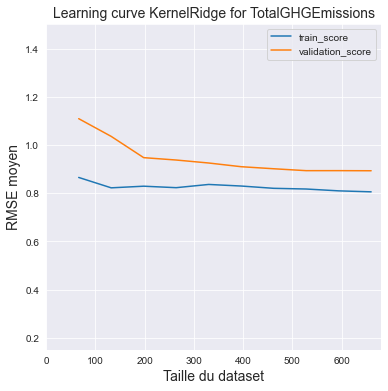

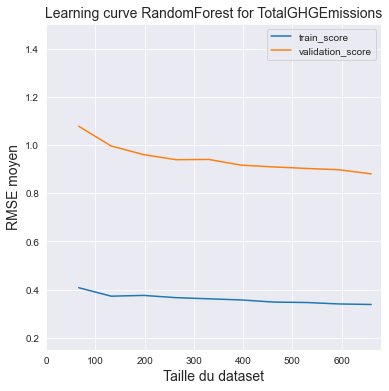

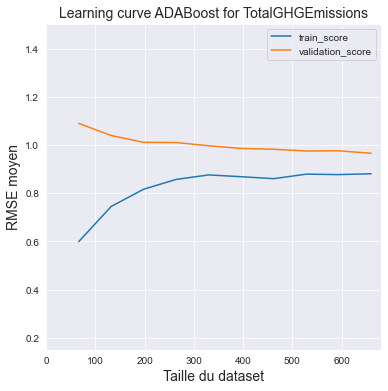

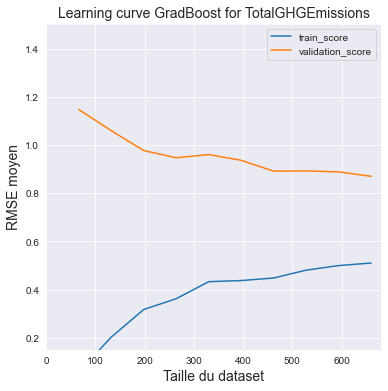

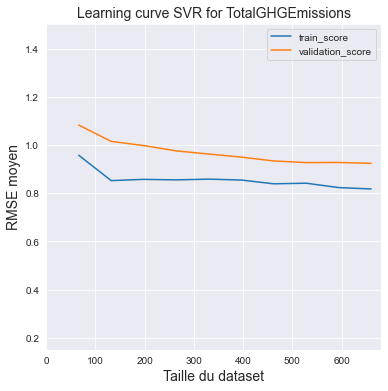

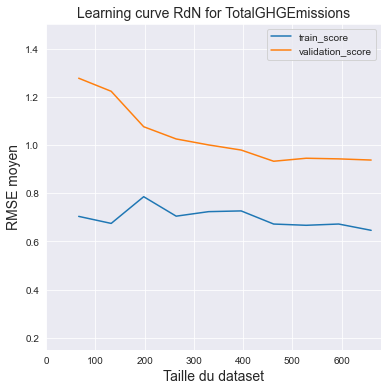

In [126]:
display_learning_curve2(dic_best_CO2, 'TotalGHGEmissions', 1.505,3.2,0.15,0.05)

On a diminué l'amplitude du RMSE lors de l'apprentissage pour le KernelRidge en optimisant les hyperparamètres, de même pour le Réseau de neurones.

Les autres courbes ont un comportement similaire à celles sans optimisation.

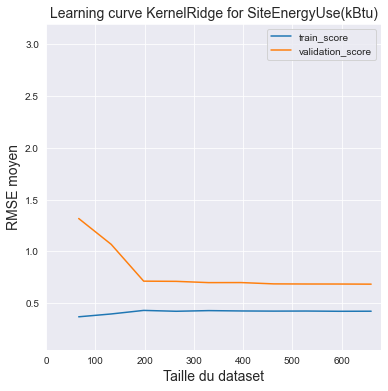

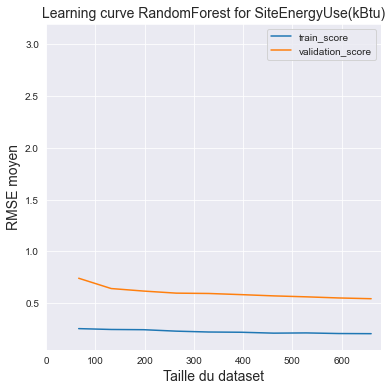

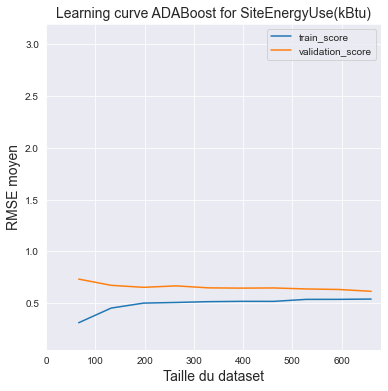

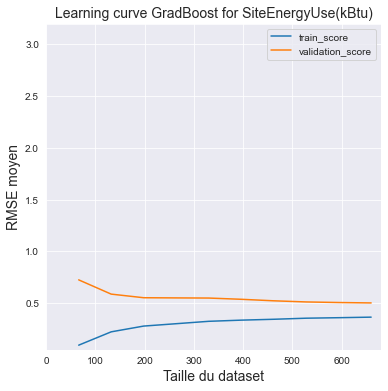

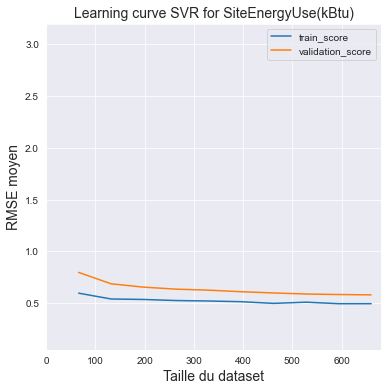

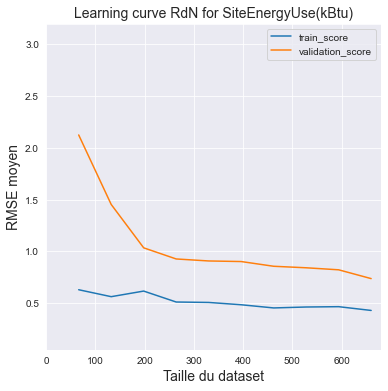

In [90]:
display_learning_curve2(dic_best_energy, 'SiteEnergyUse(kBtu)', 1.505,3.2,0.15,0.05)

Pour le KernelRidge, on a toujours une forte pente négative au début, mais qui se stabilise rapidement, de même pour le Réseau de Neurones.

Les autres courbes ont un comportement similaire à celles sans optimisation.

#### Comparaison des résultats
On rassemble les résultats dans un seul dataframe.

In [92]:
results_finaux_GridCV = pd.concat([KernelRidgeReg_all_results,
                                   RandomForest_all_results,
                                   ADA_all_results,
                                   GradB_all_results,
                                   SVR_all_results,
                                   RdN_all_results], 
                                  axis = 0).reset_index(drop =True)
results_finaux_GridCV

,modèle,target,RMSE,MAE,RMSE_GridCV,R2,Fit_Time
0,KernelRidgeReg,TotalGHGEmissions,1.024953,0.799954,0.893720,0.668198,0.022507
1,KernelRidgeReg,SiteEnergyUse(kBtu),0.946538,0.621684,0.684246,0.888923,0.022399
2,RandomForest,TotalGHGEmissions,0.891907,0.720713,0.878684,0.941909,0.458634
3,RandomForest,SiteEnergyUse(kBtu),0.546448,0.388127,0.540739,0.974299,0.538669
4,AdaBoost,TotalGHGEmissions,0.972632,0.810348,0.961926,0.595664,0.190714
5,AdaBoost,SiteEnergyUse(kBtu),0.630421,0.465148,0.611961,0.820906,0.134881
6,GradBoost,TotalGHGEmissions,0.865830,0.695331,0.864726,0.846338,0.113553
7,GradBoost,SiteEnergyUse(kBtu),0.509155,0.366144,0.503779,0.911691,0.145104
8,SVReg,TotalGHGEmissions,0.924905,0.714850,0.923852,0.664723,0.027459
9,SVReg,SiteEnergyUse(kBtu),0.583533,0.404933,0.580466,0.852768,0.031286


In [93]:
# Représentation sous forme de barplot de l'évolution du score de RMSE sur le jeu d'entrainement 
# pour les modèles testés avant/après GridSearchCV
# prend en paramètres le dataframe df contenant les résultats, la variable cible target

def evolution_RMSE(df, target) :
    
    # dataframe avec la bonne target
    df1 = df.loc[df['target']== target]
    
    # initialisation de la figure
    ax = df1.plot(x="modèle", y=["RMSE", "RMSE_GridCV"], kind="bar", colormap = 'viridis', figsize=(15,8))
    plt.ylabel('RMSE moyen', size = 14)
    plt.xlabel('Modèle', size = 14)
    ax.set_xticklabels(df['modèle'].unique(),  size=13, rotation = 0)
    
    # ajout des étiquettes pour afficher valeurs de RMSE
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12)
    plt.title('RMSE moyen avant/après GridSearchCV pour {}'.format(target), size = 14)
    
    plt.show()

In [98]:
# Représentation sous forme de barplot des scores de R2 obtenus sur le jeu d'entrainement pour les modèles testés
# prend en paramètre le dataframe df contenant les résultats

def plot_result_R2(df) :
    
    # initialisation de la figure
    plt.figure(figsize=(15,8))
    
    # barplot
    ax =sns.barplot(x='modèle', y ='R2', data = df, hue = 'target')
    plt.ylabel('R2-score', size = 14)
    plt.xlabel('Modèle', size = 14)
    ax.set_xticklabels(df['modèle'].unique(),  size=13)
    
    # ajout des étiquettes pour afficher valeurs de MAE
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12) 
    plt.legend(loc ='lower right')
    plt.show()

In [101]:
# Représentation sous forme de barplot des temps d'entrainement obtenus sur le jeu d'entrainement 
# pour les modèles testés
# prend en paramètre le dataframe df contenant les résultats

def plot_result_fit_time(df) :
    
    # initialisation de la figure
    plt.figure(figsize=(15,8))
    
    # barplot
    ax =sns.barplot(x='modèle', y ='Fit_Time', data = df, hue = 'target')
    plt.ylabel('Fit Time (s)', size = 14)
    plt.xlabel('Modèle', size = 14)
    ax.set_xticklabels(df['modèle'].unique(),  size=13)
    plt.legend()
    
    # ajout des étiquettes pour afficher valeurs de MAE
    for p in ax.patches: 
        ax.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12) 

    plt.show()

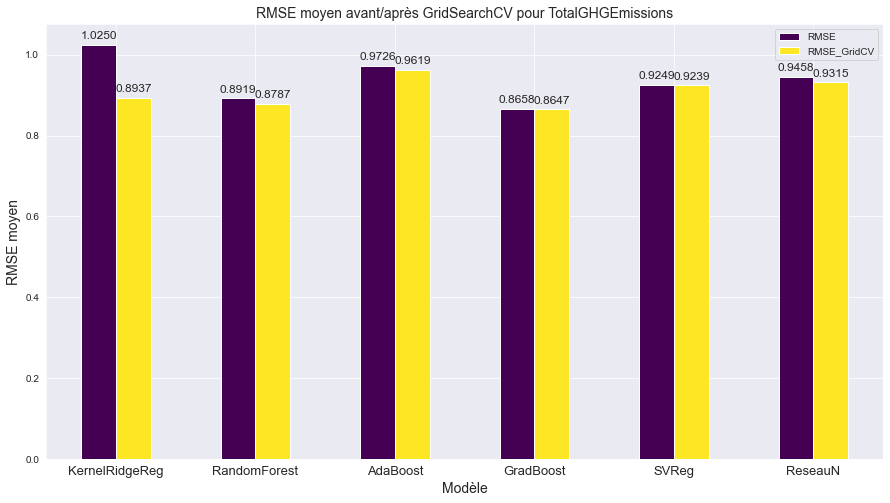

In [95]:
evolution_RMSE(results_finaux_GridCV, 'TotalGHGEmissions')

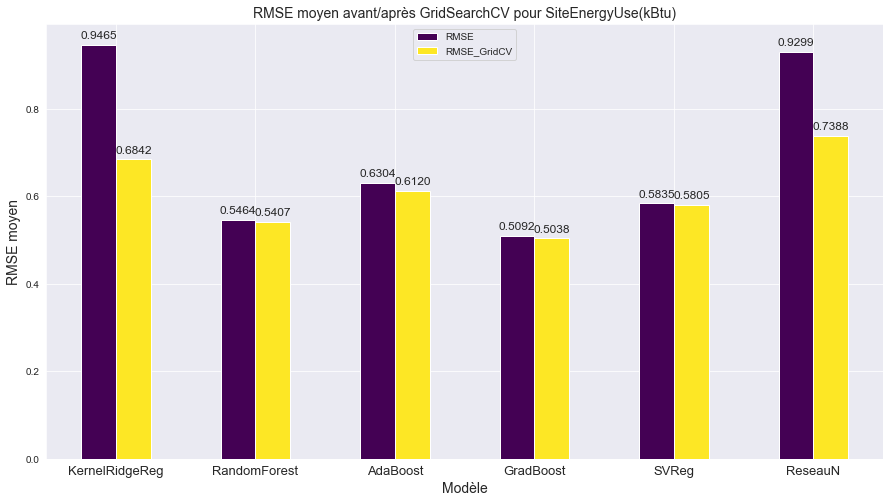

In [96]:
evolution_RMSE(results_finaux_GridCV, 'SiteEnergyUse(kBtu)')

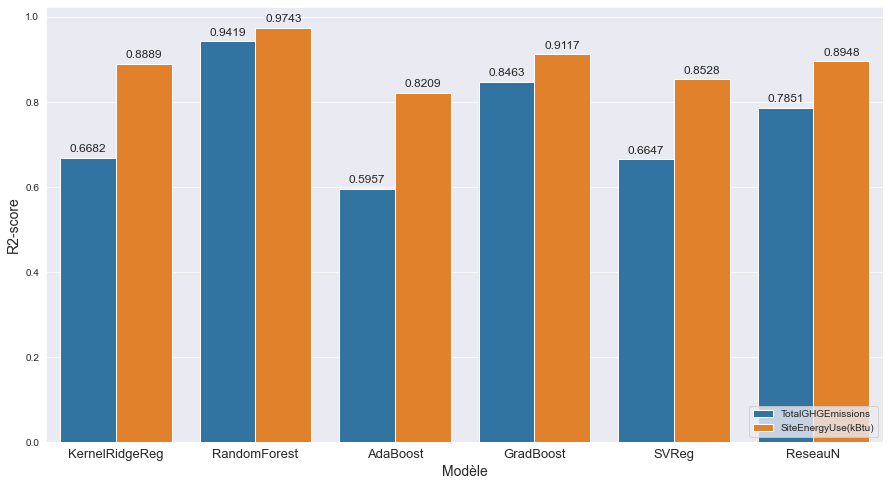

In [99]:
plot_result_R2(results_finaux_GridCV)

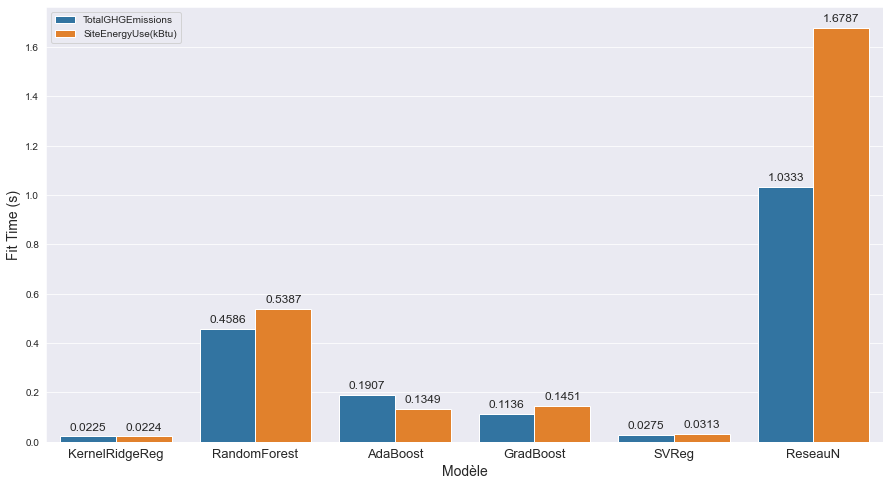

In [102]:
plot_result_fit_time(results_finaux_GridCV)

### 4.3. Amélioration du meilleur modèle

On va encore essayer d'améliorer le modèle de GradBoosting.

In [103]:
# Création d'un dictionnaire d'hyperparamètres pour GradientBoosting 

# Nombre d'estimators (par défaut, estimator = DecisionTreeRegressor)
n_estimators_CO2 = [int(x) for x in np.linspace(90,110,11)]
n_estimators_energy = [int(x) for x in np.linspace(190,210,11)]
# par défaut 100 

# Valeurs pour le learning_rate
learning_rate = np.arange(0.05,0.5,0.05) # par défaut 0.1

# Maximum depth of the individual regression estimators
max_depth = [2,3,4] # par défaut 3

# Création de la grille d'hyperparamètres
hyper_params_GradBoost_CO2 = {'gradientboostingregressor__n_estimators' : n_estimators_CO2,
                              'gradientboostingregressor__learning_rate' : learning_rate,
                              'gradientboostingregressor__max_depth' : max_depth
                             }

hyper_params_GradBoost_energy = {'gradientboostingregressor__n_estimators' : n_estimators_energy,
                              'gradientboostingregressor__learning_rate' : learning_rate,
                              'gradientboostingregressor__max_depth' : max_depth
                             }

# Score pour sélectionner le modèle optimal
score = 'neg_root_mean_squared_error'

In [104]:
GradBoost_best_param_CO2 = best_param('TotalGHGEmissions', GradBoost, hyper_params_GradBoost_CO2, score )

Best paramètres : 
 -  gradientboostingregressor__learning_rate : 0.1
 -  gradientboostingregressor__max_depth : 4
 -  gradientboostingregressor__n_estimators : 90

 Sur le jeu entrainement : 
- r2_score : 0.8360
- RMSE moyenne : 0.8608 +/- 0.0595
- Temps d'entrainement : 0.1074 s 



On est passé de 0.8647 à 0.8608 pour le RMSE, par contre le score de r2 a diminué.

In [105]:
GradBoost_best_param_energy = best_param('SiteEnergyUse(kBtu)', GradBoost, hyper_params_GradBoost_energy, score )

Best paramètres : 
 -  gradientboostingregressor__learning_rate : 0.1
 -  gradientboostingregressor__max_depth : 2
 -  gradientboostingregressor__n_estimators : 198

 Sur le jeu entrainement : 
- r2_score : 0.9114
- RMSE moyenne : 0.5036 +/- 0.0398
- Temps d'entrainement : 0.1369 s 



On est passé de 0.5038 à 0.5036 pour le RMSE, par contre le score de r2 a très légèrement diminué.

In [106]:
# Création des modèles avec ces données 
GradBoost_best_CO2 = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators = 90,
                                                                 max_depth = 4,
                                                                 random_state=42))
GradBoost_best_energy = make_pipeline(preprocessor,GradientBoostingRegressor(n_estimators = 198,
                                                                 max_depth = 2,
                                                                 random_state=42))

### 4.4. Features importance du meilleur modèle

On va regarder l'importance des variables dans le modèle final pour évaluer l'intérêt de ENERGYSTARScore.

#### SiteEnergyUse(kBtu)

In [107]:
# Split des données
X_train_energy, y_train_energy = X_y(trainset,'SiteEnergyUse(kBtu)')
X_test_energy, y_test_energy = X_y(testset,'SiteEnergyUse(kBtu)')

In [108]:
# Affichage des étapes de la pipeline
GradBoost_best_energy

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['PropertyGFATotal',
                                                   'NumberofFloors',
                                                   'NumberofBuildings',
                                                   'BuildingAge',
                                                   'ENERGYSTARScore']),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=2, n_estimators=198,
                                           random_state=42))])

In [109]:
# Entrainement du modèle
GradBoost_best_energy.fit(X_train_energy, y_train_energy)

# Récupération du nom des colonnes catégorielles
onehot_columns = list(GradBoost_best_energy.named_steps[
    'columntransformer'].named_transformers_['one_hot'].get_feature_names(input_features=cat_columns))

# Récupération du nom des colonnes numériques
numeric_features_list = list(num_columns)

# Fusion des 2 listes
numeric_features_list.extend(onehot_columns)

# On met les features importance dans un dataframe
feat_imp_energy = pd.DataFrame(GradBoost_best_energy.named_steps['gradientboostingregressor'].feature_importances_, 
             index =numeric_features_list )

In [110]:
# Retourne le nombre total de variables
len(numeric_features_list)

37

In [111]:
# Fonction pour récupérer les variables catégorielles d'origine 
# et supprimer celles créer lors du OneHotEncoder
# prend en paramètre le dataframe df des feature_importance

def var_cat(df) :
    
    #transposition du dataframe
    tr = df.transpose() 
    
    # récupération des noms de colonnes pour chaque variable
    neigh_list = [col for col in tr.columns if 'Neighborhood' in col]
    primary_list = [col for col in tr.columns if 'PrimaryPro' in col]
    
    #création des nouvelles colonnes
    tr['Neighborhood'] = tr[neigh_list].sum(axis=1)
    tr['PrimaryPropertyType'] = tr[primary_list].sum(axis=1)
    
    #suppression des anciennes colonnes
    tr = tr.drop(neigh_list+primary_list, axis = 1)
    
    return tr.transpose() #retransposition

In [114]:
# Fonction pour afficher les features importance et pour évaluer l'importance de ENERGYSTARScore
# prend en paramètre le dataframe df qui retourne les valeurs de features importances

def feature_importance (df) :
    
    # Représentation sous forme de plotbar des features importance
    ax1 = df.plot.bar(figsize=(6,6), legend = False)
    
    # Rajoute valeurs des features importance aud-dessus des barres
    for p in ax1.patches: 
        ax1.annotate(format((p.get_height()),'.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 9), 
                   textcoords='offset points',
               fontsize=12) 
    plt.ylabel('Features importance')
    plt.show()
    
    # Récupère la valeur de ENERGYSTARScore
    feat_imp_ENERGYSTARScore = df.loc['ENERGYSTARScore',0]
    
    # Liste des valeurs : autres features et ENERGYSTARScore
    feat_imp_value = [1 - feat_imp_ENERGYSTARScore, feat_imp_ENERGYSTARScore]
    
    # Représentation sous forme de pie-chart de l'importance de ENERGYSTARScore par rapport aux autres variables
    ax2 = plt.pie(feat_imp_value , labels = ['Autres variables', 'ENERGYSTARScore'],   autopct='%1.1f%%')
    plt.title('Feature_importance de ENERGYSTARScore vs les autres variables', size = 14)
    
    plt.show()

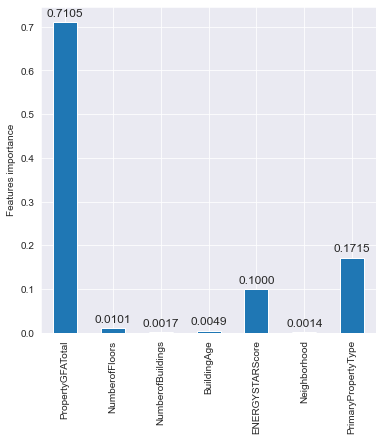

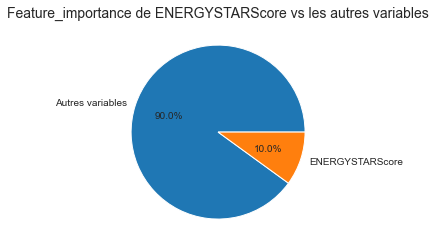

In [115]:
feature_importance(var_cat(feat_imp_energy))

ENERGYSTARScore a un intérêt limité, il arrive en 3ème position dans l'ordre des features, bien loin de PropertyGFATotal.

On remarque la 2ème place pour le PrimaryPropertyType.

#### TotalGHGEmissions

In [116]:
X_train_CO2, y_train_CO2 = X_y(trainset,'TotalGHGEmissions')
X_test_CO2, y_test_CO2 = X_y(testset,'TotalGHGEmissions')

In [117]:
# Entrainement du modèle
GradBoost_best_CO2.fit(X_train_CO2, y_train_CO2)

# Récupération du nom des colonnes catégorielles
onehot_columns = list(GradBoost_best_CO2.named_steps[
    'columntransformer'].named_transformers_['one_hot'].get_feature_names(input_features=cat_columns))

# Récupération du nom des colonnes numériques
numeric_features_list = list(num_columns)

# Fusion des 2 listes
numeric_features_list.extend(onehot_columns)

# On met les features importance dans un dataframe
feat_imp_CO2 = pd.DataFrame(GradBoost_best_CO2.named_steps['gradientboostingregressor'].feature_importances_, 
             index =numeric_features_list )

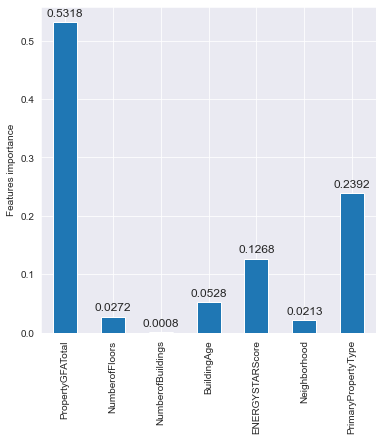

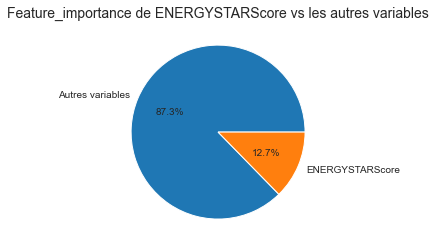

In [119]:
feature_importance(var_cat(feat_imp_CO2))

ENERGYSTARScore a un intérêt limité, il arrive en 3ème position dans l'ordre des features, loin de PropertyGFATotal.

## 5. Evaluation du modèle final

### 5.1. SiteEnergyUse(kBtu)

In [121]:
# Récupération des variables prédictes
y_pred_energy = GradBoost_best_energy.predict(X_test_energy)

# Calcul du r2-score
r2_energy = GradBoost_best_energy.score(X_test_energy, y_test_energy)

# Calcul du RMSE
RMSE_energy = np.sqrt(mean_squared_error(y_test_energy, y_pred_energy))
print('Pour SiteEnergyUse(kBtu) :')
print('- r2_score : ', r2_energy)
print('- RMSE : ', RMSE_energy)

Pour SiteEnergyUse(kBtu) :
- r2_score :  0.8791186401646328
- RMSE :  0.46006983104183913


La RMSE est plus faible sur le jeu de test, alors que le r2-score est un peu moins bon.

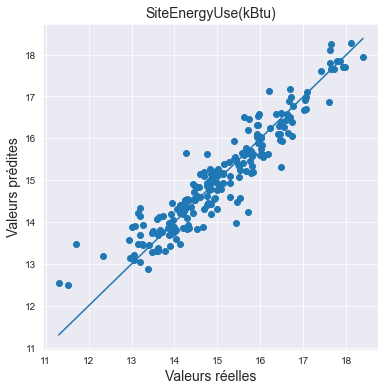

In [122]:
# Visualisation des erreurs
plt.figure(figsize=(6,6))
plt.scatter(y_test_energy, y_pred_energy)
plt.xlabel('Valeurs réelles', size = 14)
plt.ylabel('Valeurs prédites', size = 14)
plt.title('SiteEnergyUse(kBtu)', size = 14)

# 1ère bissectrice pour voir les écarts
x_max = max(y_test_energy.max(), y_pred_energy.max())
x_min = min(y_test_energy.min(), y_pred_energy.min())
plt.plot([x_min, x_max],[x_min, x_max])
plt.show()

Le modèle a une assez bonne prédiction. Par contre il a plus de mal sur les valeurs basses.

### 5.2. TotalGHGEmissions

In [123]:
# Récupération des variables prédictes
y_pred_CO2 = GradBoost_best_CO2.predict(X_test_CO2)

# Calcul du r2-score
r2_CO2 = GradBoost_best_CO2.score(X_test_CO2, y_test_CO2)

RMSE_CO2 = np.sqrt(mean_squared_error(y_test_CO2, y_pred_CO2))
print('Pour TotalGHGEmissions :')
print('- r2_score : ', r2_CO2)
print('- RMSE : ', RMSE_CO2)

Pour TotalGHGEmissions :
- r2_score :  0.6559892557330822
- RMSE :  0.849136344370042


Sur le jeu de test, on a un score de r2 nettement moins bon et une RMSE un peu meilleure.

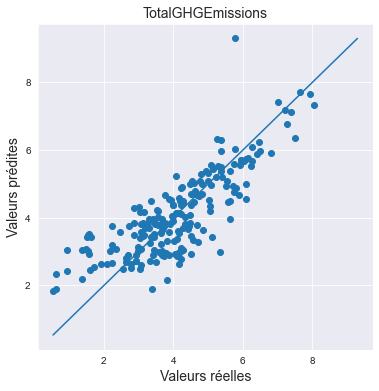

In [124]:
# Visualisation des erreurs
plt.figure(figsize=(6,6))
plt.scatter(y_test_CO2, y_pred_CO2)
plt.xlabel('Valeurs réelles', size = 14)
plt.ylabel('Valeurs prédites', size = 14)
plt.title('TotalGHGEmissions', size = 14)

# 1ère bissectrice pour voir les écarts
x_max = max(y_test_CO2.max(), y_pred_CO2.max())
x_min = min(y_test_CO2.min(), y_pred_CO2.min())
plt.plot([x_min, x_max],[x_min, x_max])
plt.show()

Le modèle a encore une marge de progression.